<a href="https://colab.research.google.com/github/henrycgbaker/nlp_research_note/blob/main/research_note.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !pip install datasets fasttext evaluate

import os
import kagglehub
import pandas as pd
import numpy as np
from datasets import load_dataset
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
import spacy
import spacy.cli
from sklearn.feature_extraction.text import CountVectorizer
import fasttext.util as fasttext_util
import fasttext
from sklearn.metrics import f1_score
from collections import Counter
from torch.utils.data import DataLoader
import torch.nn as nn
import torch
import tqdm
import pickle
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, EarlyStoppingCallback
import evaluate
from sklearn.metrics import f1_score, accuracy_score
import warnings
import sys
from sklearn.metrics import f1_score
from tqdm import tqdm

warnings.filterwarnings("ignore")

/Users/henrybaker/miniconda3/envs/nlp_1/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Hertie server
'''
import os
# Set the environment variables
os.environ['HOME_CONFIG'] = './/workspace/workspace'
os.environ['KAGGLE_CONFIG'] = './workspace/workspace/.kaggle'
os.environ['SPACY_CACHE'] = '/workspace/workspace/cache'

# Optionally, check if the environment variables were set correctly
print(os.getenv('HOME_CONFIG'))
print(os.getenv('KAGGLE_CONFIG'))
print(os.getenv('SPACY_CACHE'))
'''

"\nimport os\n# Set the environment variables\nos.environ['HOME_CONFIG'] = './/workspace/workspace'\nos.environ['KAGGLE_CONFIG'] = './workspace/workspace/.kaggle'\nos.environ['SPACY_CACHE'] = '/workspace/workspace/cache'\n\n# Optionally, check if the environment variables were set correctly\nprint(os.getenv('HOME_CONFIG'))\nprint(os.getenv('KAGGLE_CONFIG'))\nprint(os.getenv('SPACY_CACHE'))\n"

In [3]:

# download pretrained embeddings -----------------------------------------------
# for local
#fasttext.util.download_model('en', if_exists='ignore')
ft_path = "./cc.en.300.bin"

# for Colab
# !pip install datasets fasttext evaluate
#from google.colab import drive
#drive.mount('/content/drive')
#os.chdir('/content/drive/Othercomputers/My MacBook Pro/Documents/repositories/nlp/nlp_research_note')
#ft_path = "./cc.en.300.bin"

ft = fasttext.load_model(ft_path)

# download spacy model for tokenization ----------------------------------------
cache_path = './cache/'
os.makedirs(cache_path, exist_ok=True)
os.environ['SPACY_DATA'] = cache_path
spacy.cli.download("en_core_web_sm")

# load helper functions & scripts ----------------------------------------------
'''
sys.path.append('./aux_scripts')
from  misinfo_tokenizer import (get_trained_tokenizer,
                                batch_tokenize,
                                #vocab_mapping,
                                custom_analyzer
                                )
from data_loader_helpers import (#Collator,
                                 embedding_mapping_fasttext
                                 )
'''

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 334.3 kB/s eta 0:00:0000:0100:02
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


"\nsys.path.append('./aux_scripts')\nfrom  misinfo_tokenizer import (get_trained_tokenizer,\n                                batch_tokenize,\n                                #vocab_mapping,\n                                custom_analyzer\n                                )\nfrom data_loader_helpers import (#Collator,\n                                 embedding_mapping_fasttext\n                                 )\n"

---
# Import & process Hugging Face `misinfo` dataset

In [4]:
hf_cache_dir = os.getenv("HF_DATASETS_CACHE", "./cache/huggingface/datasets")
dataset_path = os.path.join(hf_cache_dir, "roupenminassian", "twitter-misinformation")

if os.path.exists(dataset_path):
    print(f"Dataset found in cache: {dataset_path}")
    ds = load_dataset("roupenminassian/twitter-misinformation", cache_dir=hf_cache_dir)
else:
    print(f"Dataset not found in cache. Downloading...")
    ds = load_dataset("roupenminassian/twitter-misinformation")

print(f'Cache Directory: \n{hf_cache_dir}')
print(f'\nExternal Structure: \n{ds.shape}')
print(f'\nInternal Structure: \n{ds["train"]}')

Dataset not found in cache. Downloading...
Cache Directory: 
./cache/huggingface/datasets

External Structure: 
{'train': (92394, 4), 'test': (10267, 4)}

Internal Structure: 
Dataset({
    features: ['Unnamed: 0.1', 'Unnamed: 0', 'text', 'label'],
    num_rows: 92394
})


In [5]:
# DATA PARTITIONING =====================================================================
ds_cloned = ds.copy()

ds_cloned['train'] = ds_cloned['train'].remove_columns(['Unnamed: 0', 'Unnamed: 0.1'])
ds_cloned['test'] = ds_cloned['test'].remove_columns(['Unnamed: 0', 'Unnamed: 0.1'])

df_misinfo_train = pd.DataFrame(ds_cloned['train'], columns=["text", "label"])
df_misinfo_test = pd.DataFrame(ds_cloned['test'], columns=["text", "label"])

df_misinfo_train = df_misinfo_train.sample(n=5000, random_state=42) # REMOVE THIS
df_misinfo_test = df_misinfo_test.sample(n=5000, random_state=42) # REMOVE THIS

print(f"Train shape {df_misinfo_train.shape} \n")
print('\n0: factual, 1: misinformation\n')
print("Training positive vs negative examples: \n", df_misinfo_train.value_counts("label")/df_misinfo_train.shape[0])
print("\nTesting positive vs negative examples: \n",df_misinfo_test.value_counts("label")/df_misinfo_test.shape[0])

df_misinfo_train.head()

Train shape (5000, 2) 


0: factual, 1: misinformation

Training positive vs negative examples: 
 label
0    0.646
1    0.354
Name: count, dtype: float64

Testing positive vs negative examples: 
 label
0    0.6548
1    0.3452
Name: count, dtype: float64


,text,label
62905,"A sudden there was a flood on the road, and th...",0
48977,"No food, no FEMA: Hurricane Michael’s survivor...",0
20691,"President Trump visits Florida hospital, prai...",1
32672,"During my 2nd week at @sacbee_news, I covered ...",0
70612,"Irma is a 5 category hurricane, and your prior...",0


In [6]:
# DEFINE TOKENIZATION FLOW =====================================================================

nlp = spacy.load("en_core_web_sm", 
                 disable=["tok2vec", "tagger", "parser", "ner", "lemmatizer", "attribute_ruler"])

def custom_tokenizer(text):
    tokenized_text = nlp(text)
    return [tok.text for tok in tokenized_text]

def custom_analyzer(text, trained_tokenizer):
    """
    Uses the custom_tokenizer, then replaces out-of-vocabulary tokens with <unk>.
    """
    tokens = custom_tokenizer(text)
    vocab = trained_tokenizer.vocabulary_
    return [token if token in vocab else "<unk>" for token in tokens]

def get_trained_tokenizer(text_series, tokenizer_file=None, min_df=3):
    """
    1) Checks if a previously fitted tokenizer exists in tokenizer_file.
    2) If not, create a new CountVectorizer, fit it on 'text_series'.
    3) Save the fitted tokenizer if tokenizer_file is provided.
    4) Return the tokenizer.
    """
    # If a tokenizer file path is given and exists, load it
    if tokenizer_file and os.path.exists(tokenizer_file):
        print(f"Tokenizer file '{tokenizer_file}' found. Loading it...")
        with open(tokenizer_file, 'rb') as f:
            tokenizer = pickle.load(f)
    else:
        # Otherwise, create a new one and fit
        print("No pre-fitted tokenizer found or no file specified. Creating a new one...")
        tokenizer = CountVectorizer(
            analyzer="word",
            tokenizer=custom_tokenizer,  # We define custom_tokenizer for splitting
            lowercase=False,
            min_df=min_df
        )
        tokenizer.fit(text_series)
        
        # Save the tokenizer if a path was provided
        if tokenizer_file:
            print(f"Saving fitted tokenizer to '{tokenizer_file}'...")
            with open(tokenizer_file, 'wb') as f:
                pickle.dump(tokenizer, f)

    return tokenizer

def batch_tokenize(text_series, batch_size, analyzer_func):
    """
    Tokenizes a Pandas Series of text in batches to avoid memory issues.
    """
    tokenized_result = []
    total = len(text_series)
    num_batches = (total // batch_size) + (1 if total % batch_size != 0 else 0)
    
    for batch_idx in range(0, total, batch_size):
        
        # Print progress every 200 batches or at the last batch
        if (batch_idx // batch_size + 1) % 200 == 0 or (batch_idx + batch_size >= total):
            print(f'Tokenizing batch {batch_idx // batch_size + 1} of {num_batches}...')
        
        batch_texts = text_series[batch_idx : batch_idx + batch_size]
        for text in batch_texts:
            tokenized_result.append(analyzer_func(text))
    
    return tokenized_result

# TOKENIZATION ==========================================================================

TOKENIZER_DIR = './cache/misinfo_tokenizer.pkl'
TRAIN_TOKENISED_DIR = './cache/misinfo_train_tokenised.pkl'
TEST_TOKENISED_DIR = './cache/misinfo_test_tokenised.pkl'

if os.path.exists(TRAIN_TOKENISED_DIR) and os.path.exists(TEST_TOKENISED_DIR):
    print("Tokenized text pkl files found: loading data...")
    # Load pre-saved tokenized data
    with open(TRAIN_TOKENISED_DIR, 'rb') as f:
        misinfo_train_tokenised = pickle.load(f)
    with open(TEST_TOKENISED_DIR, 'rb') as f:
        misinfo_test_tokenised = pickle.load(f)

else:
    print("Pickle files not found. Running tokenization...")

    # 1) Train tokenizer
    misinfo_tokenizer = get_trained_tokenizer(
        df_misinfo_train["text"],
        tokenizer_file=TOKENIZER_DIR,
        min_df=3
    )

    # Build the default analyzer from our tokenizer
    misinfo_tokenizer_analyzer = misinfo_tokenizer.build_analyzer()

    # 2) Tokenize train data in batches using the built analyzer (trained on train set)
    print("Tokenizing Train Data in Batches...")
    misinfo_train_tokenised = batch_tokenize(
        df_misinfo_train["text"],
        32,
        misinfo_tokenizer_analyzer
    )
    
    # 3) Tokenize test data in batches using custom_analyzer (which replaces OOV tokens with <unk>)
    print("Tokenizing Test Data in Batches...")
    misinfo_test_tokenised = batch_tokenize(
        df_misinfo_test["text"],
        32,
        lambda text: custom_analyzer(text, trained_tokenizer=misinfo_tokenizer)
    )

    # Optionally, save the tokenized data
    with open(TRAIN_TOKENISED_DIR, 'wb') as f:
        pickle.dump(misinfo_train_tokenised, f)
    with open(TEST_TOKENISED_DIR, 'wb') as f:
        pickle.dump(misinfo_test_tokenised, f)

print("Train inputs tokenised:", len(misinfo_train_tokenised))
print("Test inputs tokenised:", len(misinfo_test_tokenised))

Pickle files not found. Running tokenization...
No pre-fitted tokenizer found or no file specified. Creating a new one...
Saving fitted tokenizer to './cache/misinfo_tokenizer.pkl'...
Tokenizing Train Data in Batches...
Tokenizing batch 157 of 157...
Tokenizing Test Data in Batches...
Tokenizing batch 157 of 157...
Train inputs tokenised: 5000
Test inputs tokenised: 5000


In [7]:
# STEP 1: INPUT PIPELINE ================================================================

# vocabulary indexing -------------------------------------------------------------------

def vocab_mapping(tokenized_text):
    token_counts = Counter()
    for text in tokenized_text:
        token_counts.update(text)
    special_tokens = ["<pad>", "<unk>"]
    vocab_tokens = special_tokens + [token for token, freq in token_counts.most_common()]
    vocab = {token: idx for idx, token in enumerate(vocab_tokens)}
    return vocab

vocab_idx = vocab_mapping(tokenized_text=misinfo_train_tokenised)

print(f"Vocab size: {len(vocab_idx)}")
print(f"Vocab example: {list(vocab_idx.items())[:10]}")

Vocab size: 46425
Vocab example: [('<pad>', 0), ('<unk>', 1), ('the', 2), (',', 3), ('.', 4), ('to', 5), ('of', 6), ('and', 7), ('a', 8), ('in', 9)]


In [8]:
# create data loaders -------------------------------------------------------------------

def collate_fn(data, include_lengths=True):
    text_list, label_list, lengths = [], [], []
    for _text, _label in data:
        # Integer encoding with truncation
        processed_text = torch.tensor([vocab_idx[token] for token in _text][:max_seq_length],
                                      dtype=torch.int64)
        text_list.append(processed_text)
        label_list.append(_label)
        lengths.append(processed_text.size(0))
    label_list = torch.tensor(label_list)
    lengths = torch.tensor(lengths)
    # Padding
    padded_text_list = nn.utils.rnn.pad_sequence(text_list,
                                                 batch_first=True,
                                                 padding_value=0)
    if include_lengths:
        return padded_text_list, label_list, lengths
    else:
        return padded_text_list, label_list

max_seq_length = 300 # too long for classic RNN
batch_size = 32

# standard dls with collate_fn
train_dl = DataLoader(dataset=list(zip(misinfo_train_tokenised,
                                         df_misinfo_train["label"])),
                        batch_size=32, shuffle=True, 
                        collate_fn=lambda x: collate_fn(x, include_lengths=True))

test_dl = DataLoader(dataset=list(zip(misinfo_test_tokenised,
                                         df_misinfo_test["label"])),
                        batch_size=32, shuffle=False, 
                        collate_fn=lambda x: collate_fn(x, include_lengths=True))

# dls w/o collate_fn for CNNs:
train_dl_cnn = DataLoader(dataset=list(zip(misinfo_train_tokenised,
                                         df_misinfo_train["label"])),
                        batch_size=32, shuffle=True,
                        collate_fn=lambda x: collate_fn(x, include_lengths=False))

test_dl_cnn = DataLoader(dataset=list(zip(misinfo_test_tokenised,
                                         df_misinfo_test["label"])),
                         batch_size=32, shuffle=True,
                        collate_fn=lambda x: collate_fn(x, include_lengths=False))

In [9]:
# EMBEDDING MAPPING =====================================================================

# map pretrained fasttext embeddings to vocabulary indices ------------------------------

EMBEDDINGS_FILE_PATH = "./cache/mapped_pretrained_embeddings.pkl"

def embedding_mapping_fasttext(vocabulary, pre_trained_embeddings):
    vocab_size = len(vocabulary)
    embedding_dim = pre_trained_embeddings.get_dimension()
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    for idx, word in enumerate(vocabulary):
        embedding_matrix[idx] = pre_trained_embeddings.get_word_vector(word)
    return embedding_matrix

if os.path.exists(EMBEDDINGS_FILE_PATH):
    with open(EMBEDDINGS_FILE_PATH, 'rb') as f:
        embedding_tensor = pickle.load(f)
    print(f"Emebddings pre-exists: loaded embeddings from {EMBEDDINGS_FILE_PATH}. Shape: {embedding_tensor.shape}")
else:
    print("Embeddings do not pre-exist: mapping pretrained fasttext embeddings to vocabulary indices")

    mapped_pretrained_embeddings = embedding_mapping_fasttext(vocabulary=vocab_idx,
                                                              pre_trained_embeddings=ft)
    embedding_tensor = torch.FloatTensor(mapped_pretrained_embeddings)

    # Save embeddings
    with open(EMBEDDINGS_FILE_PATH, 'wb') as f:
        pickle.dump(embedding_tensor, f)
    print(f"Saved embeddings to {EMBEDDINGS_FILE_PATH}. Shape: {embedding_tensor.shape}")


Embeddings do not pre-exist: mapping pretrained fasttext embeddings to vocabulary indices
Saved embeddings to ./cache/mapped_pretrained_embeddings.pkl. Shape: torch.Size([46425, 300])


In [10]:
def train(model, num_epochs, train_dl, test_dl, use_lengths=False):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    loss_fn = nn.BCEWithLogitsLoss()

    device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    model.to(device)

    metrics = {
        "loss_train": [],
        "loss_test": [],
        "accuracy_train": [],
        "accuracy_test": [],
        "f1_train": [],
        "f1_test": []
    }

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss, train_correct = 0, 0
        all_train_preds, all_train_labels = [], []

        print(f"Epoch {epoch + 1}/{num_epochs} Training...")
        for batch in tqdm(train_dl, desc="Training", leave=False):
            if use_lengths:
                x_batch, y_batch, lengths = batch
                x_batch, y_batch, lengths = x_batch.to(device), y_batch.to(device), lengths.to(device)
                pred = model(x_batch, lengths)[:, 0]  # Include lengths for RNNs/LSTMs
            else:
                x_batch, y_batch = batch
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                pred = model(x_batch)[:, 0]

            # Compute loss
            loss = loss_fn(pred, y_batch.float())

            # Backpropagation
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            # Metrics
            train_loss += loss.item() * y_batch.size(0)
            preds = (pred >= 0.5).float()
            train_correct += (preds == y_batch).float().sum().item()
            all_train_preds.extend(preds.cpu().numpy())
            all_train_labels.extend(y_batch.cpu().numpy())

        metrics["loss_train"].append(train_loss / len(train_dl.dataset))
        metrics["accuracy_train"].append(train_correct / len(train_dl.dataset))
        metrics["f1_train"].append(f1_score(all_train_labels, all_train_preds))

        # Evaluation phase
        model.eval()
        test_loss, test_correct = 0, 0
        all_test_preds, all_test_labels = [], []
        print(f"Epoch {epoch + 1}/{num_epochs} Evaluating...")
        with torch.no_grad():
            for batch in tqdm(test_dl, desc="Evaluating", leave=False):
                if use_lengths:
                    x_batch, y_batch, lengths = batch
                    x_batch, y_batch, lengths = x_batch.to(device), y_batch.to(device), lengths.to(device)
                    pred = model(x_batch, lengths)[:, 0]
                else:
                    x_batch, y_batch = batch
                    x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                    pred = model(x_batch)[:, 0]

                # Compute loss
                loss = loss_fn(pred, y_batch.float())

                # Metrics
                test_loss += loss.item() * y_batch.size(0)
                preds = (pred >= 0.5).float()
                test_correct += (preds == y_batch).float().sum().item()
                all_test_preds.extend(preds.cpu().numpy())
                all_test_labels.extend(y_batch.cpu().numpy())

        metrics["loss_test"].append(test_loss / len(test_dl.dataset))
        metrics["accuracy_test"].append(test_correct / len(test_dl.dataset))
        metrics["f1_test"].append(f1_score(all_test_labels, all_test_preds))

        # Print summary
        print(f"Epoch {epoch + 1}/{num_epochs} Summary:")
        print(f"    Train - Loss: {metrics['loss_train'][-1]:.4f}, Accuracy: {metrics['accuracy_train'][-1]:.3f}, F1: {metrics['f1_train'][-1]:.3f}")
        print(f"    Test  - Loss: {metrics['loss_test'][-1]:.4f}, Accuracy: {metrics['accuracy_test'][-1]:.3f}, F1: {metrics['f1_test'][-1]:.3f}")

    return metrics

In [11]:
# MODEL BUILDING ================================================================

# CNN-based text classification model

class TextClassificationModel(nn.Module):
    # create layers
    def __init__(self, embedding_tensor):
        super().__init__()
        # input layer
        self.embedding_layer = nn.Embedding.from_pretrained(embedding_tensor, freeze=True)
        # hidden layers
        convolution_layer = nn.Conv1d(in_channels=embedding_tensor.size(1),
                                      out_channels=128,
                                      kernel_size=3,
                                      padding="same")
        activation_layer = nn.ReLU()
        pooling_layer = nn.AdaptiveAvgPool1d(1)
        h_layers = [convolution_layer, activation_layer, pooling_layer]
        self.hidden_layers = nn.ModuleList(h_layers)
        # classification layer
        self.classification_layer = nn.Linear(in_features=128, out_features=1)

    # define forward pass
    def forward(self, x):
        x = self.embedding_layer(x).permute(0, 2, 1)

        for layer in self.hidden_layers:
            x = layer(x)

        x = x.squeeze(2)

        x = self.classification_layer(x)
        return x

model_cnn = TextClassificationModel(embedding_tensor=embedding_tensor)

In [12]:
# Train the model
num_epochs = 10

hist_cnn = train(model_cnn, num_epochs, train_dl_cnn, test_dl_cnn, use_lengths=False)

with open("./models/train_hist/cnn_hist.pkl", "wb") as f:
    pickle.dump(hist_cnn, f)
    
torch.save(model_cnn, "./models/cnn_model.pth")

Using device: mps
Epoch 1/10 Training...


Epoch 1/10 Evaluating...


Epoch 1/10 Summary:
    Train - Loss: 0.5413, Accuracy: 0.742, F1: 0.431
    Test  - Loss: 0.4735, Accuracy: 0.810, F1: 0.628
Epoch 2/10 Training...


Epoch 2/10 Evaluating...


Epoch 2/10 Summary:
    Train - Loss: 0.4366, Accuracy: 0.813, F1: 0.648
    Test  - Loss: 0.4213, Accuracy: 0.819, F1: 0.650
Epoch 3/10 Training...


Epoch 3/10 Evaluating...


Epoch 3/10 Summary:
    Train - Loss: 0.3934, Accuracy: 0.833, F1: 0.694
    Test  - Loss: 0.3950, Accuracy: 0.830, F1: 0.682
Epoch 4/10 Training...


Epoch 4/10 Evaluating...


Epoch 4/10 Summary:
    Train - Loss: 0.3679, Accuracy: 0.839, F1: 0.709
    Test  - Loss: 0.3739, Accuracy: 0.829, F1: 0.676
Epoch 5/10 Training...


Epoch 5/10 Evaluating...


Epoch 5/10 Summary:
    Train - Loss: 0.3480, Accuracy: 0.843, F1: 0.718
    Test  - Loss: 0.3579, Accuracy: 0.833, F1: 0.687
Epoch 6/10 Training...


Epoch 6/10 Evaluating...


Epoch 6/10 Summary:
    Train - Loss: 0.3312, Accuracy: 0.846, F1: 0.725
    Test  - Loss: 0.3495, Accuracy: 0.833, F1: 0.687
Epoch 7/10 Training...


Epoch 7/10 Evaluating...


Epoch 7/10 Summary:
    Train - Loss: 0.3181, Accuracy: 0.848, F1: 0.730
    Test  - Loss: 0.3348, Accuracy: 0.843, F1: 0.715
Epoch 8/10 Training...


Epoch 8/10 Evaluating...


Epoch 8/10 Summary:
    Train - Loss: 0.3074, Accuracy: 0.848, F1: 0.732
    Test  - Loss: 0.3239, Accuracy: 0.843, F1: 0.712
Epoch 9/10 Training...


Epoch 9/10 Evaluating...


Epoch 9/10 Summary:
    Train - Loss: 0.2928, Accuracy: 0.853, F1: 0.742
    Test  - Loss: 0.3192, Accuracy: 0.850, F1: 0.731
Epoch 10/10 Training...


Epoch 10/10 Evaluating...


Epoch 10/10 Summary:
    Train - Loss: 0.2850, Accuracy: 0.857, F1: 0.752
    Test  - Loss: 0.3081, Accuracy: 0.849, F1: 0.728


In [13]:
# EXTENSION 1: RNN =====================================================================

class RNNTextClassificationModel(nn.Module):
    # create layers
    def __init__(self, embedding_tensor):
        super().__init__()
        # input layer
        self.embedding_layer = nn.Embedding.from_pretrained(embedding_tensor, freeze=True)
        # hidden layer
        self.rnn_layer = nn.RNN(input_size=embedding_tensor.size(1),
                                hidden_size=32,
                                num_layers=1, # increase to stack RNNs
                                batch_first=True)
        # classification layer
        self.classification_layer = nn.Linear(in_features=32, out_features=1)

    # define forward pass
    def forward(self, x, lengths):
        x = self.embedding_layer(x)
        x = nn.utils.rnn.pack_padded_sequence(x,
                                              lengths.cpu().numpy(),
                                              enforce_sorted=False,
                                              batch_first=True)
        o_t, h_t = self.rnn_layer(x) # o_t includes the outputs,
                                     # h_t the hidden state at the last time step
        x = h_t[-1, :, :] # extract from last layer (in case of num_layers > 1)
        x = self.classification_layer(x)
        return x

model_rnn = RNNTextClassificationModel(embedding_tensor=embedding_tensor)
hist_rnn = train(model_rnn, num_epochs, train_dl, test_dl, use_lengths=True) # fluctuating f1 scores, exploding gradients

with open("./models/train_hist/rnn_hist.pkl", "wb") as f:
    pickle.dump(hist_rnn, f)

torch.save(model_rnn, "./models/rnn_model.pth")

Using device: mps
Epoch 1/10 Training...


Epoch 1/10 Evaluating...


Epoch 1/10 Summary:
    Train - Loss: 0.5848, Accuracy: 0.657, F1: 0.081
    Test  - Loss: 0.5134, Accuracy: 0.749, F1: 0.572
Epoch 2/10 Training...


Epoch 2/10 Evaluating...


Epoch 2/10 Summary:
    Train - Loss: 0.4408, Accuracy: 0.780, F1: 0.622
    Test  - Loss: 0.3977, Accuracy: 0.823, F1: 0.695
Epoch 3/10 Training...


Epoch 3/10 Evaluating...


Epoch 3/10 Summary:
    Train - Loss: 0.4872, Accuracy: 0.753, F1: 0.608
    Test  - Loss: 0.4288, Accuracy: 0.807, F1: 0.657
Epoch 4/10 Training...


Epoch 4/10 Evaluating...


Epoch 4/10 Summary:
    Train - Loss: 0.4607, Accuracy: 0.773, F1: 0.628
    Test  - Loss: 0.5279, Accuracy: 0.703, F1: 0.282
Epoch 5/10 Training...


Epoch 5/10 Evaluating...


Epoch 5/10 Summary:
    Train - Loss: 0.4825, Accuracy: 0.728, F1: 0.440
    Test  - Loss: 0.4635, Accuracy: 0.754, F1: 0.523
Epoch 6/10 Training...


Epoch 6/10 Evaluating...


Epoch 6/10 Summary:
    Train - Loss: 0.3651, Accuracy: 0.834, F1: 0.732
    Test  - Loss: 0.3764, Accuracy: 0.839, F1: 0.757
Epoch 7/10 Training...


Epoch 7/10 Evaluating...


Epoch 7/10 Summary:
    Train - Loss: 0.3177, Accuracy: 0.864, F1: 0.795
    Test  - Loss: 0.3460, Accuracy: 0.856, F1: 0.784
Epoch 8/10 Training...


Epoch 8/10 Evaluating...


Epoch 8/10 Summary:
    Train - Loss: 0.5536, Accuracy: 0.705, F1: 0.326
    Test  - Loss: 0.5579, Accuracy: 0.678, F1: 0.138
Epoch 9/10 Training...


Epoch 9/10 Evaluating...


Epoch 9/10 Summary:
    Train - Loss: 0.5239, Accuracy: 0.689, F1: 0.240
    Test  - Loss: 0.5315, Accuracy: 0.704, F1: 0.286
Epoch 10/10 Training...


Epoch 10/10 Evaluating...


Epoch 10/10 Summary:
    Train - Loss: 0.4692, Accuracy: 0.769, F1: 0.592
    Test  - Loss: 0.5719, Accuracy: 0.692, F1: 0.306


In [14]:
# EXTENSION 2: LSTM =====================================================================

class LSTMTextClassificationModel(nn.Module):
    # create layers
    def __init__(self, embedding_tensor):
        super().__init__()
        # input layer
        self.embedding_layer = nn.Embedding.from_pretrained(embedding_tensor, freeze=True)
        # hidden layer
        self.lstm_layer = nn.LSTM(input_size=embedding_tensor.size(1),
                                  hidden_size=32,
                                  num_layers=1,
                                  batch_first=True)
        # classification layer
        self.classification_layer = nn.Linear(in_features=32, out_features=1)

    # define forward pass
    def forward(self, x, lengths):
        x = self.embedding_layer(x)
        x = nn.utils.rnn.pack_padded_sequence(x,
                                              lengths.cpu().numpy(),
                                              enforce_sorted=False,
                                              batch_first=True)
        o_t, (h_t, c_t) = self.lstm_layer(x) # c_t the cell state at the last time step
        x = h_t[-1, :, :] # extract from last layer (in case of num_layers > 1)
        x = self.classification_layer(x)
        return x

model_lstm = LSTMTextClassificationModel(embedding_tensor=embedding_tensor)

hist_lstm = train(model_lstm, num_epochs=10, train_dl=train_dl, test_dl=test_dl, use_lengths=True)

with open("./models/train_hist/lstm_hist.pkl", "wb") as f:
    pickle.dump(hist_lstm, f)
    
torch.save(model_lstm, "./models/lstm_model.pth")

Using device: mps
Epoch 1/10 Training...


Epoch 1/10 Evaluating...


Epoch 1/10 Summary:
    Train - Loss: 0.5976, Accuracy: 0.647, F1: 0.006
    Test  - Loss: 0.5113, Accuracy: 0.663, F1: 0.051
Epoch 2/10 Training...


Epoch 2/10 Evaluating...


Epoch 2/10 Summary:
    Train - Loss: 0.4723, Accuracy: 0.701, F1: 0.336
    Test  - Loss: 0.5220, Accuracy: 0.737, F1: 0.529
Epoch 3/10 Training...


Epoch 3/10 Evaluating...


Epoch 3/10 Summary:
    Train - Loss: 0.4886, Accuracy: 0.735, F1: 0.446
    Test  - Loss: 0.4324, Accuracy: 0.777, F1: 0.563
Epoch 4/10 Training...


Epoch 4/10 Evaluating...


Epoch 4/10 Summary:
    Train - Loss: 0.3715, Accuracy: 0.821, F1: 0.695
    Test  - Loss: 0.3813, Accuracy: 0.812, F1: 0.647
Epoch 5/10 Training...


Epoch 5/10 Evaluating...


Epoch 5/10 Summary:
    Train - Loss: 0.4796, Accuracy: 0.775, F1: 0.674
    Test  - Loss: 0.4782, Accuracy: 0.742, F1: 0.500
Epoch 6/10 Training...


Epoch 6/10 Evaluating...


Epoch 6/10 Summary:
    Train - Loss: 0.4176, Accuracy: 0.775, F1: 0.591
    Test  - Loss: 0.4269, Accuracy: 0.743, F1: 0.442
Epoch 7/10 Training...


Epoch 7/10 Evaluating...


Epoch 7/10 Summary:
    Train - Loss: 0.3379, Accuracy: 0.832, F1: 0.721
    Test  - Loss: 0.3375, Accuracy: 0.844, F1: 0.736
Epoch 8/10 Training...


Epoch 8/10 Evaluating...


Epoch 8/10 Summary:
    Train - Loss: 0.3049, Accuracy: 0.863, F1: 0.784
    Test  - Loss: 0.3452, Accuracy: 0.835, F1: 0.701
Epoch 9/10 Training...


Epoch 9/10 Evaluating...


Epoch 9/10 Summary:
    Train - Loss: 0.2662, Accuracy: 0.886, F1: 0.827
    Test  - Loss: 0.2909, Accuracy: 0.863, F1: 0.770
Epoch 10/10 Training...


Epoch 10/10 Evaluating...


Epoch 10/10 Summary:
    Train - Loss: 0.2462, Accuracy: 0.897, F1: 0.844
    Test  - Loss: 0.2696, Accuracy: 0.883, F1: 0.822


In [15]:
# EXTENSION 2.5: STACKING LSTM LAYERS WITH DIFFERENT HIDDEN SIZES =========================

class StackedLSTMTextClassificationModel(nn.Module):
    # create layers
    def __init__(self, embedding_tensor):
        super().__init__()
        # input layer
        self.embedding_layer = nn.Embedding.from_pretrained(embedding_tensor, freeze=True)
        # hidden layer
        self.lstm_layer_1 = nn.LSTM(input_size=embedding_tensor.size(1),
                                    hidden_size=64,
                                    num_layers=1,
                                    batch_first=True)
        self.lstm_layer_2 = nn.LSTM(input_size=64,
                                    hidden_size=32,
                                    num_layers=1,
                                    batch_first=True)
        # classification layer
        self.classification_layer = nn.Linear(in_features=32, out_features=1)

    # define forward pass
    def forward(self, x, lengths):
        x = self.embedding_layer(x)
        x = nn.utils.rnn.pack_padded_sequence(x,
                                              lengths.cpu().numpy(),
                                              enforce_sorted=False,
                                              batch_first=True)
        o_t_1, (h_t_1, c_t_1) = self.lstm_layer_1(x)
        o_t_2, (h_t_2, c_t_2) = self.lstm_layer_2(o_t_1)
        x = h_t_2[-1, :, :]
        x = self.classification_layer(x)
        return x

model_lstm_stacked = StackedLSTMTextClassificationModel(embedding_tensor=embedding_tensor)
hist_lstm_stacked = train(model_lstm_stacked, num_epochs, train_dl, test_dl, use_lengths=True)

with open("./models/train_hist/lstm_stacked_hist.pkl", "wb") as f:
    pickle.dump(hist_lstm_stacked, f)

torch.save(model_lstm_stacked, "./models/lstm_stacked_model.pth")

Using device: mps
Epoch 1/10 Training...


Epoch 1/10 Evaluating...


Epoch 1/10 Summary:
    Train - Loss: 0.5795, Accuracy: 0.662, F1: 0.102
    Test  - Loss: 0.4925, Accuracy: 0.757, F1: 0.481
Epoch 2/10 Training...


Epoch 2/10 Evaluating...


Epoch 2/10 Summary:
    Train - Loss: 0.4520, Accuracy: 0.781, F1: 0.640
    Test  - Loss: 0.3677, Accuracy: 0.829, F1: 0.698
Epoch 3/10 Training...


Epoch 3/10 Evaluating...


Epoch 3/10 Summary:
    Train - Loss: 0.3735, Accuracy: 0.839, F1: 0.762
    Test  - Loss: 0.7458, Accuracy: 0.606, F1: 0.623
Epoch 4/10 Training...


Epoch 4/10 Evaluating...


Epoch 4/10 Summary:
    Train - Loss: 0.4254, Accuracy: 0.763, F1: 0.629
    Test  - Loss: 0.3408, Accuracy: 0.846, F1: 0.782
Epoch 5/10 Training...


Epoch 5/10 Evaluating...


Epoch 5/10 Summary:
    Train - Loss: 0.3649, Accuracy: 0.841, F1: 0.767
    Test  - Loss: 0.5022, Accuracy: 0.679, F1: 0.161
Epoch 6/10 Training...


Epoch 6/10 Evaluating...


Epoch 6/10 Summary:
    Train - Loss: 0.3712, Accuracy: 0.814, F1: 0.711
    Test  - Loss: 0.3677, Accuracy: 0.830, F1: 0.766
Epoch 7/10 Training...


Epoch 7/10 Evaluating...


Epoch 7/10 Summary:
    Train - Loss: 0.3779, Accuracy: 0.819, F1: 0.741
    Test  - Loss: 0.3364, Accuracy: 0.844, F1: 0.764
Epoch 8/10 Training...


Epoch 8/10 Evaluating...


Epoch 8/10 Summary:
    Train - Loss: 0.2839, Accuracy: 0.876, F1: 0.818
    Test  - Loss: 0.2964, Accuracy: 0.862, F1: 0.783
Epoch 9/10 Training...


Epoch 9/10 Evaluating...


Epoch 9/10 Summary:
    Train - Loss: 0.2492, Accuracy: 0.897, F1: 0.848
    Test  - Loss: 0.3010, Accuracy: 0.838, F1: 0.707
Epoch 10/10 Training...


Epoch 10/10 Evaluating...


Epoch 10/10 Summary:
    Train - Loss: 0.2069, Accuracy: 0.914, F1: 0.871
    Test  - Loss: 0.2288, Accuracy: 0.897, F1: 0.837


In [16]:
# EXTENSION 4: BI-DIRECTIONAL LSTM ======================================================

class BidirectionalLSTMTextClassificationModel(nn.Module):
    # create layers
    def __init__(self, embedding_tensor):
        super().__init__()
        # input layer
        self.embedding_layer = nn.Embedding.from_pretrained(embedding_tensor, freeze=True)
        # hidden layer
        self.bid_lstm_layer = nn.LSTM(input_size=embedding_tensor.size(1),
                                      hidden_size=32,
                                      num_layers=1,
                                      batch_first=True,
                                      bidirectional=True)
        # classification layer
        self.classification_layer = nn.Linear(in_features=32*2, out_features=1)

    # define forward pass
    def forward(self, x, lengths):
        x = self.embedding_layer(x)
        x = nn.utils.rnn.pack_padded_sequence(x,
                                              lengths.cpu().numpy(),
                                              enforce_sorted=False,
                                              batch_first=True)
        o_t, (h_t, c_t) = self.bid_lstm_layer(x)
        x = torch.cat((h_t[-2, :, :],
                       h_t[-1, :, :]), dim=1)
        x = self.classification_layer(x)
        return x

model_bi_lstm = BidirectionalLSTMTextClassificationModel(embedding_tensor=embedding_tensor)

hist_bi_lstm = train(model_bi_lstm, num_epochs, train_dl, test_dl, use_lengths=True)

with open("./models/train_hist/bi_lstm_hist.pkl", "wb") as f:
    pickle.dump(hist_bi_lstm, f)

torch.save(model_bi_lstm, "./models/bi_lstm_model.pth")

Using device: mps
Epoch 1/10 Training...


Epoch 1/10 Evaluating...


Epoch 1/10 Summary:
    Train - Loss: 0.4503, Accuracy: 0.733, F1: 0.419
    Test  - Loss: 0.2394, Accuracy: 0.897, F1: 0.833
Epoch 2/10 Training...


Epoch 2/10 Evaluating...


Epoch 2/10 Summary:
    Train - Loss: 0.1779, Accuracy: 0.921, F1: 0.882
    Test  - Loss: 0.1463, Accuracy: 0.934, F1: 0.901
Epoch 3/10 Training...


Epoch 3/10 Evaluating...


Epoch 3/10 Summary:
    Train - Loss: 0.1184, Accuracy: 0.948, F1: 0.924
    Test  - Loss: 0.1392, Accuracy: 0.936, F1: 0.902
Epoch 4/10 Training...


Epoch 4/10 Evaluating...


Epoch 4/10 Summary:
    Train - Loss: 0.0995, Accuracy: 0.955, F1: 0.935
    Test  - Loss: 0.1261, Accuracy: 0.946, F1: 0.920
Epoch 5/10 Training...


Epoch 5/10 Evaluating...


Epoch 5/10 Summary:
    Train - Loss: 0.0827, Accuracy: 0.965, F1: 0.950
    Test  - Loss: 0.1219, Accuracy: 0.949, F1: 0.925
Epoch 6/10 Training...


Epoch 6/10 Evaluating...


Epoch 6/10 Summary:
    Train - Loss: 0.0737, Accuracy: 0.967, F1: 0.953
    Test  - Loss: 0.1284, Accuracy: 0.946, F1: 0.919
Epoch 7/10 Training...


Epoch 7/10 Evaluating...


Epoch 7/10 Summary:
    Train - Loss: 0.0666, Accuracy: 0.971, F1: 0.958
    Test  - Loss: 0.1194, Accuracy: 0.950, F1: 0.926
Epoch 8/10 Training...


Epoch 8/10 Evaluating...


Epoch 8/10 Summary:
    Train - Loss: 0.0561, Accuracy: 0.974, F1: 0.963
    Test  - Loss: 0.1365, Accuracy: 0.947, F1: 0.920
Epoch 9/10 Training...


Epoch 9/10 Evaluating...


Epoch 9/10 Summary:
    Train - Loss: 0.0575, Accuracy: 0.975, F1: 0.964
    Test  - Loss: 0.1219, Accuracy: 0.950, F1: 0.926
Epoch 10/10 Training...


Epoch 10/10 Evaluating...


Epoch 10/10 Summary:
    Train - Loss: 0.0460, Accuracy: 0.980, F1: 0.971
    Test  - Loss: 0.1318, Accuracy: 0.949, F1: 0.925


# Transformer & Transfer Learning

In [17]:
from datasets import Dataset, DatasetDict, Features, Value, ClassLabel

# Load checkpoint and tokenizer
checkpoint = "google/bert_uncased_L-2_H-128_A-2"
bert_tokenizer = AutoTokenizer.from_pretrained(checkpoint)
bert_uncased = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google/bert_uncased_L-2_H-128_A-2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [18]:
# Define the features of the dataset
features = Features({
    'text': Value(dtype='string'),
    'label': ClassLabel(num_classes=2, names=['factual', 'misinfo']),
})

df_misinfo_train = df_misinfo_train.reset_index(drop=True)
df_misinfo_test = df_misinfo_test.reset_index(drop=True)

# Convert train and test data to Hugging Face Dataset
dataset_train = Dataset.from_pandas(df_misinfo_train, features=features)
dataset_test = Dataset.from_pandas(df_misinfo_test, features=features)

# Display the first few rows of the training dataset
print(dataset_train[2]) 

# Check the unique values of the 'label' column to ensure the classes are correct
unique_labels = set(dataset_train['label'])
print("Unique label values in training data:", unique_labels)

# Check the mapping of integer labels to class names
print("Class name mapping:", dataset_train.features['label'].int2str)

# Create a Hugging Face DatasetDict
dataset_dict = DatasetDict({
    'train': dataset_train,
    'test': dataset_test
})

# Print the DatasetDict to check its contents
print(f'\n {dataset_dict}')

print(dataset_train[2]) 
print(dataset_dict['train'][2])

{'text': ' President Trump visits Florida hospital, praises first responders following school shooting:  It s very sad something like that could happen, but the job the doctors did, the nurses, the hospital, the first responders, law enforcement   really incredible. A White House statement said that the Trumps were visiting  to pay their respects and thank the medical professionals for their life-saving assistance  in response to shooting.NEW: "The job they ve done is incredible," Pres. Trump says of doctors, first responders as he and first lady Melania Trump meet Parkland shooting victims at Broward Health North Hospital https://t.co/n6Ltn0H0nn pic.twitter.com/gKN8aHbRz4  CBS News (@CBSNews) February 17, 2018POTUS AND FLOTUS THEN MET WITH FLORIDA LAW ENFORCEMENT:After President Trump and First Lady Melania visited with victims, families and the incredible medical teams at Broward Health North   they headed to thank the amazing law enforcement officers at the @BrowardSheriff s Departm

In [19]:
# tokenize ------------------------------------------------------------------------------
def tokenize_function(dataset):
    return bert_tokenizer(dataset["text"], truncation=True, padding="max_length", max_length=512)
    # truncates at 512 for the chosen checkpoint

tokenized_datasets = dataset_dict.map(tokenize_function, batched=True)
tokenized_datasets

tokenized_datasets['train'][0]['text']
tokenized_datasets['train'][0]['label']
tokenized_datasets['train'][0]['input_ids']
tokenized_datasets['train'][0]['attention_mask']

# fine-tune -----------------------------------------------------------------------------
training_args = TrainingArguments(output_dir="./transformer_results/bert_uncased",
                                  eval_strategy="epoch",
                                  save_strategy="epoch",
                                  per_device_train_batch_size=32,
                                  per_device_eval_batch_size=32,
                                  num_train_epochs=30,
                                  load_best_model_at_end=True,
                                  metric_for_best_model='f1',
                                  disable_tqdm=False,
                                  use_cpu=False)

def compute_metrics(eval_preds):
    metric = evaluate.load("glue", "mrpc")
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

trainer = Trainer(
    bert_uncased,
    training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

trainer.train()

# Save the model and tokenizer after training
trainer.save_model("./models/transformer_results")  
bert_tokenizer.save_pretrained("./models/transformer_results")  

Map: 100%|██████████| 5000/5000 [00:01<00:00, 4338.26 examples/s]
                                                  
  3%|▎         | 157/4710 [01:05<38:20,  1.98it/s]

{'eval_loss': 0.2487318068742752, 'eval_accuracy': 0.9322, 'eval_f1': 0.9019947961838681, 'eval_runtime': 17.8979, 'eval_samples_per_second': 279.363, 'eval_steps_per_second': 8.772, 'epoch': 1.0}


                                                    
  7%|▋         | 314/4710 [02:08<17:04,  4.29it/s]

{'eval_loss': 0.1135304793715477, 'eval_accuracy': 0.9632, 'eval_f1': 0.9476975554292212, 'eval_runtime': 17.9256, 'eval_samples_per_second': 278.93, 'eval_steps_per_second': 8.758, 'epoch': 2.0}


                                                    
 10%|█         | 471/4710 [03:11<19:42,  3.59it/s]

{'eval_loss': 0.09109988808631897, 'eval_accuracy': 0.9688, 'eval_f1': 0.9554540262707024, 'eval_runtime': 17.1711, 'eval_samples_per_second': 291.186, 'eval_steps_per_second': 9.143, 'epoch': 3.0}


 11%|█         | 500/4710 [03:19<19:57,  3.52it/s]  

{'loss': 0.239, 'grad_norm': 2.7938454151153564, 'learning_rate': 4.469214437367304e-05, 'epoch': 3.18}


                                                  
 13%|█▎        | 628/4710 [04:13<15:17,  4.45it/s]

{'eval_loss': 0.09751715511083603, 'eval_accuracy': 0.9686, 'eval_f1': 0.954663586485706, 'eval_runtime': 18.0933, 'eval_samples_per_second': 276.346, 'eval_steps_per_second': 8.677, 'epoch': 4.0}


                                                    
 17%|█▋        | 785/4710 [05:14<18:13,  3.59it/s]

{'eval_loss': 0.09592843055725098, 'eval_accuracy': 0.9712, 'eval_f1': 0.9585014409221903, 'eval_runtime': 17.188, 'eval_samples_per_second': 290.901, 'eval_steps_per_second': 9.134, 'epoch': 5.0}


                                                    
 20%|██        | 942/4710 [06:16<17:19,  3.62it/s]

{'eval_loss': 0.10295017063617706, 'eval_accuracy': 0.9708, 'eval_f1': 0.9583333333333334, 'eval_runtime': 17.2155, 'eval_samples_per_second': 290.437, 'eval_steps_per_second': 9.12, 'epoch': 6.0}


 21%|██        | 1000/4710 [06:33<17:05,  3.62it/s] 

{'loss': 0.0568, 'grad_norm': 5.111602783203125, 'learning_rate': 3.9384288747346076e-05, 'epoch': 6.37}


                                                   
 23%|██▎       | 1099/4710 [07:18<17:03,  3.53it/s]

{'eval_loss': 0.1158042699098587, 'eval_accuracy': 0.9698, 'eval_f1': 0.9559124087591241, 'eval_runtime': 17.4745, 'eval_samples_per_second': 286.132, 'eval_steps_per_second': 8.985, 'epoch': 7.0}


                                                     
 27%|██▋       | 1256/4710 [08:20<15:35,  3.69it/s]

{'eval_loss': 0.11715184152126312, 'eval_accuracy': 0.9714, 'eval_f1': 0.9584664536741214, 'eval_runtime': 17.0541, 'eval_samples_per_second': 293.184, 'eval_steps_per_second': 9.206, 'epoch': 8.0}


 27%|██▋       | 1256/4710 [08:20<22:56,  2.51it/s]

{'train_runtime': 500.6115, 'train_samples_per_second': 299.634, 'train_steps_per_second': 9.408, 'train_loss': 0.12583174219556675, 'epoch': 8.0}


('./models/transformer_results/tokenizer_config.json',
 './models/transformer_results/special_tokens_map.json',
 './models/transformer_results/vocab.txt',
 './models/transformer_results/added_tokens.json',
 './models/transformer_results/tokenizer.json')

In [20]:
def batch_predict(model, tokenizer, texts, batch_size=16, device='mps', max_length=512):
    """
    Predict labels for a batch of texts using the specified model and tokenizer.

    Parameters:
        model: The pre-trained model (e.g., BERT).
        tokenizer: The tokenizer associated with the pre-trained model.
        texts: List of input texts to predict.
        batch_size: Number of samples per batch.
        device: Device to use ('mps', 'cuda', or 'cpu').
        max_length: Maximum sequence length for tokenization.

    Returns:
        List of predicted labels.
    """
    model.to(device)
    model.eval()

    predictions = []

    with torch.no_grad():  # No gradients needed for prediction
        for i in range(0, len(texts), batch_size):
            batch_texts = texts[i:i + batch_size]

            # Tokenize the batch with truncation and padding
            tokenized_batch = tokenizer(
                batch_texts,
                padding=True,
                truncation=True,
                max_length=max_length,
                return_tensors="pt"
            )

            # Move tokenized inputs to the same device as the model
            tokenized_batch = {key: value.to(device) for key, value in tokenized_batch.items()}

            # Get model outputs
            outputs = model(**tokenized_batch)

            # Apply softmax to logits and determine predicted labels
            preds = torch.nn.functional.softmax(outputs.logits, dim=-1)
            predicted_labels = torch.argmax(preds, dim=1)

            # Collect predictions
            predictions.extend(predicted_labels.cpu().numpy())  # Move predictions to CPU before storing

    return predictions

# USAGE
# set device
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
print(f"Using device: {device}")

# Prepare dataset
disinfo_test_texts = df_misinfo_test["text"].to_list()
true_labels = df_misinfo_test["label"].to_list()


# predictions in batches
predicted_labels = batch_predict(bert_uncased, bert_tokenizer, disinfo_test_texts, batch_size=16, device=device)

# Evaluate the performance
f1 = f1_score(true_labels, predicted_labels)
acc = accuracy_score(true_labels, predicted_labels)
print(f"F1 Score: {f1}")
print(f"Accuracy: {acc}")

Using device: mps
F1 Score: 0.9585014409221903
Accuracy: 0.9712


could do a load here about why the non-transformers didn't work so well (maybe a tweet is not long enough, didn;t do any hyperparameter tuning, non-decreasing LR means it often overshot; but of interest is that Transformers worked, so will take that moving forward)

---
# Climate Tweets

In [21]:
# reading climate df
input_path_climate = "/Users/henrybaker/.cache/kagglehub/datasets/die9origephit/climate-change-tweets/versions/1/Climate change_2022-1-17_2022-7-19.csv"
df_climate = pd.read_csv(input_path_climate)
print(f"Loading dataset from '{input_path_climate}'...")
df_climate.head()

Loading dataset from '/Users/henrybaker/.cache/kagglehub/datasets/die9origephit/climate-change-tweets/versions/1/Climate change_2022-1-17_2022-7-19.csv'...


,UserScreenName,UserName,Timestamp,Text,Embedded_text,Emojis,Comments,Likes,Retweets,Image link,Tweet URL
0,Lauren Boebert,@laurenboebert,2022-01-17T23:32:38.000Z,Lauren Boebert\n@laurenboebert\n·\nJan 18,The only solution I’ve ever heard the Left pro...,NaN,"1,683","2,259",11.7K,[],https://twitter.com/laurenboebert/status/14832...
1,Catherine,@catherine___c,2022-01-17T22:54:02.000Z,Catherine\n@catherine___c\n·\nJan 17,Climate change doesn’t cause volcanic eruption...,NaN,158,64,762,[],https://twitter.com/catherine___c/status/14832...
2,king Keith,@KaConfessor,2022-01-17T23:51:41.000Z,king Keith\n@KaConfessor\n·\nJan 18,Vaccinated tennis ball boy collapses in the te...,NaN,24,118,159,['https://pbs.twimg.com/ext_tw_video_thumb/148...,https://twitter.com/KaConfessor/status/1483225...
3,PETRIFIED CLIMATE PARENT,@climate_parent,2022-01-17T21:42:04.000Z,PETRIFIED CLIMATE PARENT\n@climate_parent\n·\n...,North America has experienced an average winte...,NaN,15,50,158,[],https://twitter.com/climate_parent/status/1483...
4,Thomas Speight,@Thomas_Sp8,2022-01-17T21:10:40.000Z,Thomas Speight\n@Thomas_Sp8\n·\nJan 17,They're gonna do the same with Climate Change ...,🅾,4,24,127,['https://pbs.twimg.com/profile_images/1544171...,https://twitter.com/Thomas_Sp8/status/14831850...


In [22]:
df_climate_inference = df_climate[['Embedded_text']].rename(columns={'Embedded_text': 'text'})
print(f"Shape of inference dataset: {df_climate_inference.shape}")
df_climate_inference.head()

Shape of inference dataset: (9050, 1)


,text
0,The only solution I’ve ever heard the Left pro...
1,Climate change doesn’t cause volcanic eruption...
2,Vaccinated tennis ball boy collapses in the te...
3,North America has experienced an average winte...
4,They're gonna do the same with Climate Change ...


In [23]:
# TRANSFORMER INFERENCE ================================================================

# Tokenize climate tweets

CLIMATE_TOKENISED_DIR = './cache/climate_tokenised.pkl'

if os.path.exists(CLIMATE_TOKENISED_DIR):
    print("Tokenized climate tweets pkl file found. Loading data...")
    with open(CLIMATE_TOKENISED_DIR, 'rb') as f:
        climate_tokenised = pickle.load(f)
else:
    print("Pickle file not found. Tokenizing climate tweets...")
    climate_tokenised = bert_tokenizer(
        list(df_climate_inference["text"]),  # Use raw text data
        truncation=True,
        padding="max_length",
        max_length=512,
        return_tensors="pt"
    )
    with open(CLIMATE_TOKENISED_DIR, 'wb') as f:
        pickle.dump(climate_tokenised, f)
    print("Tokenized climate tweets and saved to file.")

# Predict using fine-tuned BERT model
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
print(f"Using device: {device}")

def predict_climate_tweets(model, tokenized_texts, batch_size=32, device='mps'):
    model.to(device)
    model.eval()

    predictions = []
    with torch.no_grad():
        for i in range(0, len(tokenized_texts['input_ids']), batch_size):
            batch_input_ids = tokenized_texts['input_ids'][i:i + batch_size].to(device)
            batch_attention_mask = tokenized_texts['attention_mask'][i:i + batch_size].to(device)

            outputs = model(input_ids=batch_input_ids, attention_mask=batch_attention_mask)
            preds = torch.nn.functional.softmax(outputs.logits, dim=-1)
            predicted_labels = torch.argmax(preds, dim=1)
            predictions.extend(predicted_labels.cpu().numpy())

    return predictions

predicted_labels = predict_climate_tweets(bert_uncased, climate_tokenised, batch_size=32, device=device)

Pickle file not found. Tokenizing climate tweets...
Tokenized climate tweets and saved to file.
Using device: mps


In [25]:

df_climate_inference['predicted_label'] = predicted_labels

# Replace 0 with 'factual' and 1 with 'misinformation' in the 'predicted_label' column
df_climate_inference['predicted_label'] = df_climate_inference['predicted_label'].replace({0: 'factual', 1: 'misinformation'})

# Display the updated dataframe
print(df_climate_inference.head())

# Save predictions to CSV
output_path_climate = "/Users/henrybaker/Documents/repositories/nlp/nlp_research_note/data/climate_predictions_bert.csv"
df_climate_inference.to_csv(output_path_climate, index=False)
print(f"Predictions saved to {output_path_climate}.")

                                                text predicted_label
0  The only solution I’ve ever heard the Left pro...  misinformation
1  Climate change doesn’t cause volcanic eruption...         factual
2  Vaccinated tennis ball boy collapses in the te...  misinformation
3  North America has experienced an average winte...         factual
4  They're gonna do the same with Climate Change ...  misinformation
Predictions saved to /Users/henrybaker/Documents/repositories/nlp/nlp_research_note/data/climate_predictions_bert.csv.


Distribution of Factual vs Misinformation:
predicted_label
misinformation    5668
factual           3382
Name: count, dtype: int64


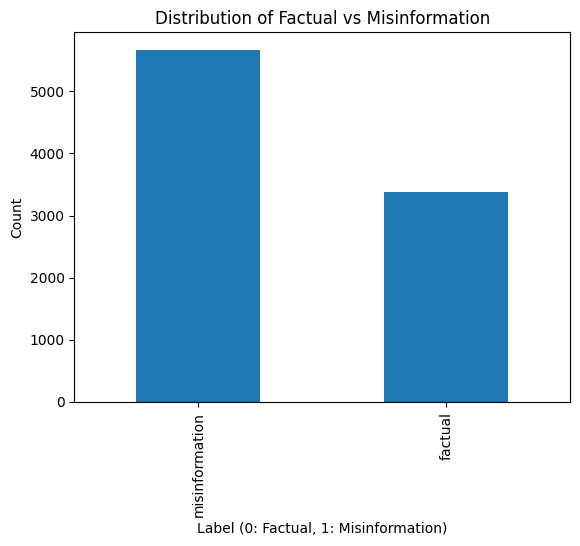

In [26]:
# Count occurrences of each label
label_counts = df_climate_inference['predicted_label'].value_counts()

print("Distribution of Factual vs Misinformation:")
print(label_counts)

# If you want to visualise this distribution:
import matplotlib.pyplot as plt

label_counts.plot(kind='bar')
plt.title('Distribution of Factual vs Misinformation')
plt.xlabel('Label (0: Factual, 1: Misinformation)')
plt.ylabel('Count')
plt.show()

learly overly categorising things as misinfo... I could retune to reduce more false positives, but given that it got 96+% on F1 score, the model is accurate to the dataset; the issue lies with either a) the internal validity of the dataset; b) the external valifity / OOD assumptions when applied to climate tweets.

a) looking at the constituent datasets, I can see how this happened...
b) climate tweets are different...inference write up: not great, overrepresentation of misinfo - prob because in the training data i used climate was disproportionately in the misinfo category -> out of distribution... generally it identifies factual well, but overly classifies as misinfo

was going to do an LDA, but unless the model is better performing, it makes more sense to do xAI to work out where it's performing badly

looking at the tweets labeled misinfo, it's clear the model doesn't understand the substantive poits / the science, it's just classifying on style

so next steps
1) clear up the tweets to remove the other text -> get it closer to the others text
2) xAI



In [28]:
# Extract 10 examples of factual (label == 0)
factual_examples = df_climate_inference[df_climate_inference['predicted_label'] == 'factual'].head(10)

# Extract 10 examples of misinformation (label == 1)
misinfo_examples = df_climate_inference[df_climate_inference['predicted_label'] == 'misinformation'].head(10)

print("10 Examples of Factual (predicted_label 0):")
print(factual_examples)

print("\n10 Examples of Misinformation (predicted_label 1):")
print(misinfo_examples)


10 Examples of Factual (predicted_label 0):
                                                 text predicted_label
1   Climate change doesn’t cause volcanic eruption...         factual
3   North America has experienced an average winte...         factual
6   fucking hell this weather makes me really fuck...         factual
11  Ronald Reagan (1989): "Because changes in the ...         factual
12  #Geopolitics could have a material impact on #...         factual
13  The climate crisis is front page news in South...         factual
17  ... don't be the person that only thinks about...         factual
18  Is this guy real? BBC News - Climate change: W...         factual
22  Toronto Ontario; the city that thought snow pl...         factual
24  They now say we have to invest in our infrastr...         factual

10 Examples of Misinformation (predicted_label 1):
                                                 text predicted_label
0   The only solution I’ve ever heard the Left pro...  misinform

In [ ]:
# pipeline for RNNs etc (need to rework / a lot not needed)
'''
vocab_idx = vocab_mapping(tokenized_text=climate_tokenised) # is this correct?? ithink not
 
climate_dl = DataLoader(
    dataset=list(zip(climate_tokenised,climate_tokenised["label"])), # THIS SHOULD BE BLANK...
    batch_size=32, 
    shuffle=False, 
    collate_fn=collate_fn)

EMBEDDINGS_FILE_PATH_CLIMATE = "./cache/mapped_pretrained_embeddings_climate.pkl"

if os.path.exists(EMBEDDINGS_FILE_PATH_CLIMATE):
    with open(EMBEDDINGS_FILE_PATH_CLIMATE, 'rb') as f:
        embedding_tensor_climate = pickle.load(f)
    print(f"Emebddings pre-exists: loaded embeddings from {EMBEDDINGS_FILE_PATH_CLIMATE}. Shape: {embedding_tensor_climate.shape}")
else:
    print("Embeddings do not pre-exist: mapping pretrained fasttext embeddings to vocabulary indices")

    mapped_pretrained_embeddings_climate = embedding_mapping_fasttext(vocabulary=vocab_idx,
                                                              pre_trained_embeddings=ft)
    embedding_tensor = torch.FloatTensor(mapped_pretrained_embeddings_climate)

    # Save embeddings
    with open(EMBEDDINGS_FILE_PATH_CLIMATE, 'wb') as f:
        pickle.dump(embedding_tensor, f)
    print(f"Saved embeddings to {EMBEDDINGS_FILE_PATH_CLIMATE}. Shape: {embedding_tensor_climate.shape}")
'''

---

# xAI

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModelForSequenceClassification
from captum.attr import IntegratedGradients, Lime
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from IPython.display import HTML, display
from matplotlib import cm, colors


In [16]:
# === Step 1: Set Device === #
device = torch.device("cpu")  # Captum doesn't support MPS
print("Using device:", device)

# === Step 2: Load Tokenized Climate Data === #
CLIMATE_TOKENISED_DIR = './cache/climate_tokenised.pkl'
with open(CLIMATE_TOKENISED_DIR, 'rb') as f:
    climate_tokenised = pickle.load(f)

subset_indices = [1, 2, 3, 4, 5]
climate_tokenised_subset = {
    "input_ids": climate_tokenised["input_ids"][subset_indices],
    "token_type_ids": climate_tokenised["token_type_ids"][subset_indices],
    "attention_mask": climate_tokenised["attention_mask"][subset_indices]
}

# === Step 3: Load Pretrained Model and Tokenizer === #
model_path = "./models/transformer_results"
bert_tokenizer = AutoTokenizer.from_pretrained(model_path)
bert_uncased_finetuned = AutoModelForSequenceClassification.from_pretrained(model_path)
bert_uncased_finetuned.to(device).eval()  # Set model to evaluation mode
print("Model and tokenizer loaded successfully from:", model_path)

# === Step 4: Convert Data to Tensors and Prepare Embeddings === #
input_ids = torch.clone(climate_tokenised_subset["input_ids"]).detach().to(dtype=torch.long, device=device)
attention_mask = torch.clone(climate_tokenised_subset["attention_mask"]).detach().to(dtype=torch.float32, device=device)

# Extract embeddings
embedding_layer = bert_uncased_finetuned.get_input_embeddings()
embeddings = embedding_layer(input_ids).clone().detach().requires_grad_(True).to(device)
print("Input IDs and embeddings prepared.")

# === Step 5: Define Forward Function === #
def forward_func(embeddings, attention_mask=None):
    outputs = bert_uncased_finetuned(inputs_embeds=embeddings, attention_mask=attention_mask)
    return torch.softmax(outputs.logits, dim=-1)  # Return probabilities

# === Step 6: Integrated Gradients Computation === #
def compute_integrated_gradients(embeddings, attention_mask, tokenizer, target_class=0, steps=50):
    """
    Compute Integrated Gradients using embeddings and attention mask.
    """
    ig = IntegratedGradients(forward_func)
    baseline = torch.zeros_like(embeddings)  # Baseline embeddings
    attributions_ig = ig.attribute(
        inputs=embeddings,
        baselines=baseline,
        additional_forward_args=(attention_mask,),
        target=target_class,
        n_steps=steps,
    )
    tokens = tokenizer.convert_ids_to_tokens(input_ids[0].cpu().numpy())
    token_attributions = attributions_ig.sum(dim=-1)[0].detach().cpu().numpy()

    # Reconstruct sentence and word-level attributions
    sentence, word_attributions = reconstruct_sentence(tokens, token_attributions, tokenizer)
    return sentence, word_attributions

# === Step 7: LIME Computation === #

def compute_lime(input_ids, attention_mask, tokenizer, model=bert_uncased_finetuned, target_class=0, n_samples=100):

    # Define a forward function for Captum
    def forward_func(input_ids, attention_mask=None):
        input_ids = input_ids.to(dtype=torch.long)
        if attention_mask is not None:
            attention_mask = attention_mask.to(dtype=torch.float32)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        return torch.softmax(outputs.logits, dim=-1)  # Return probabilities
    lime = Lime(forward_func)
    attributions_lime = lime.attribute(
        inputs=input_ids,
        n_samples=n_samples,
        additional_forward_args=(attention_mask,),
        target=target_class,
    )
    tokens = tokenizer.convert_ids_to_tokens(input_ids[0].cpu().numpy())
    token_attributions = attributions_lime[0].detach().cpu().numpy().flatten()

    sentence, word_attributions = reconstruct_sentence(tokens, token_attributions, tokenizer)
    
    return sentence, word_attributions


# === Step 8: Reconstruct Sentence and Word-Level Attributions === #
def reconstruct_sentence(tokens, attributions, tokenizer):
    """
    Reconstruct sentence and aggregate word-level attributions from token attributions.
    """
    word_tokens, word_attributions = [], []
    current_word, current_score = "", 0.0

    for token, score in zip(tokens, attributions):
        if token.startswith("##"):
            current_score += score
        else:
            if current_word:  # Save previous word
                word_tokens.append(current_word)
                word_attributions.append(current_score)
            current_word, current_score = token, score

    # Add the last word
    if current_word:
        word_tokens.append(current_word)
        word_attributions.append(current_score)

    # Filter out special tokens like [PAD], [CLS], [SEP]
    special_tokens = tokenizer.special_tokens_map.values()
    filtered_tokens = [t for t in word_tokens if t not in special_tokens]
    filtered_attributions = [
        a for t, a in zip(word_tokens, word_attributions) if t not in special_tokens
    ]
    sentence = " ".join(filtered_tokens)
    return sentence, filtered_attributions

# === Step 9: Run and Display Results === #
for idx in range(len(climate_tokenised_subset["input_ids"])):
    print(f"\n--- Sample {idx + 1} ---")
    
    # Get embeddings and attention mask for the sample
    sample_embeddings = embeddings[idx].unsqueeze(0)
    sample_attention_mask = attention_mask[idx].unsqueeze(0)
    
    # Integrated Gradients
    sentence_ig, word_attributions_ig = compute_integrated_gradients(
        embeddings=sample_embeddings,
        attention_mask=sample_attention_mask,
        tokenizer=bert_tokenizer,
        target_class=0,
        steps=50
    )
    print(f"\nReconstructed Sentence (IG): {sentence_ig}")
    print("Word-Level Attributions (IG):")
    for word, score in zip(sentence_ig.split(), word_attributions_ig):
        print(f"{word} ({score:.4f}) ", end="")
    print("\n")
    
    # LIME
    sentence_lime, word_attributions_lime = compute_lime(
        input_ids=input_ids[idx].unsqueeze(0),
        attention_mask=sample_attention_mask,
        model=bert_uncased_finetuned,
        tokenizer=bert_tokenizer,
        target_class=0,
        n_samples=100
    )
    print(f"\nReconstructed Sentence (LIME): {sentence_lime}")
    print("Word-Level Attributions (LIME):")
    for word, score in zip(sentence_lime.split(), word_attributions_lime):
        print(f"{word} ({score:.4f}) ", end="")
    print("\n")

Using device: cpu
Model and tokenizer loaded successfully from: ./models/transformer_results
Input IDs and embeddings prepared.

--- Sample 1 ---

Reconstructed Sentence (IG): climate change doesn ’ t cause volcanic eruptions . 158 64 76
Word-Level Attributions (IG):
climate (0.0910) change (0.0202) doesn (0.0047) ’ (0.0588) t (0.0972) cause (0.0762) volcanic (0.2702) eruptions (0.1674) . (0.0875) 158 (0.0184) 64 (-0.0012) 76 (0.0100) 


Reconstructed Sentence (LIME): climate change doesn ’ t cause volcanic eruptions . 158 64 76
Word-Level Attributions (LIME):
climate (0.1623) change (0.0000) doesn (-0.0428) ’ (0.0000) t (-0.0575) cause (0.0000) volcanic (0.3155) eruptions (0.2286) . (0.0000) 158 (0.0390) 64 (0.0000) 76 (0.0000) 


--- Sample 2 ---

Reconstructed Sentence (IG): climate change doesn ’ t cause volcanic eruptions . 158 64 76
Word-Level Attributions (IG):
climate (0.0869) change (0.0273) doesn (0.0051) ’ (-0.1407) t (-0.0120) cause (-0.0140) volcanic (-0.0036) eruptions (0

In [17]:
# ======== Visualization of Word-Level Attributions (Color-Coded) ======== #

def visualize_token_attributions(tokens, attributions, cmap='bwr', title="Word-Level Attributions"):
    """
    Color-code each token by its attribution score and display as HTML in a notebook.
    Filters out `[PAD]` tokens during visualization.
    
    Args:
        tokens (list): List of strings (tokens).
        attributions (list or np.array): Attribution scores (same length as tokens).
        cmap (str): Matplotlib colormap (default: 'bwr' = blue-white-red).
        title (str): Title for the visualization.
    """
    # Convert attributions to numpy if not already
    attributions = np.array(attributions)
    
    # Ensure the lengths match
    assert len(tokens) == len(attributions), "Tokens and attributions lengths do not match!"
    
    # Filter out [PAD] tokens and their attributions
    filtered_tokens, filtered_attributions = [], []
    for token, attr in zip(tokens, attributions):
        if token not in ["[PAD]", "[CLS]", "[SEP]"]:  # Ignore special tokens
            filtered_tokens.append(token)
            filtered_attributions.append(attr)
    
    # Convert filtered attributions to numpy for consistency
    filtered_attributions = np.array(filtered_attributions)
    
    # Normalise attributions for color mapping
    norm = colors.Normalize(vmin=filtered_attributions.min(), vmax=filtered_attributions.max())
    scalar_map = cm.ScalarMappable(norm=norm, cmap=cmap)
    
    # Generate HTML with colored tokens
    html_content = f"<h3>{title}</h3><div style='line-height:1.6;'>"
    for token, score in zip(filtered_tokens, filtered_attributions):
        color = colors.rgb2hex(scalar_map.to_rgba(score))
        html_content += f"<span style='background-color:{color}; padding:2px; margin:2px;'>{token}</span> "
    html_content += "</div>"
    
    # Display the HTML content
    display(HTML(html_content))

# Example: Visualize IG Word-Level Attributions
sentence_ig, word_attributions_ig = compute_integrated_gradients(
    embeddings=sample_embeddings,
    attention_mask=sample_attention_mask,
    tokenizer=bert_tokenizer,
    target_class=0,
    steps=50
)
tokens_ig = sentence_ig.split()
visualize_token_attributions(tokens_ig, word_attributions_ig, cmap='bwr', title="IG Attributions")

# Example: Visualize LIME Word-Level Attributions
sentence_lime, word_attributions_lime = compute_lime(
    input_ids=input_ids[idx].unsqueeze(0),
    attention_mask=sample_attention_mask,
    tokenizer=bert_tokenizer,
    target_class=0,
    n_samples=100
)
tokens_lime = sentence_lime.split()
visualize_token_attributions(tokens_lime, word_attributions_lime, cmap='coolwarm', title="LIME Attributions")


In [27]:
# === Workflow Settings === #
from IPython.display import display, HTML
import torch
import numpy as np
from matplotlib import cm, colors
from captum.attr import IntegratedGradients, Lime
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import pickle

# === Setup === #
device = torch.device("cpu")  # Captum doesn't support MPS
print("Using device:", device)

# Load tokenized climate data
CLIMATE_TOKENISED_DIR = './cache/climate_tokenised.pkl'
with open(CLIMATE_TOKENISED_DIR, 'rb') as f:
    climate_tokenised = pickle.load(f)

subset_indices = [1, 2, 3, 4, 5]
climate_tokenised_subset = {
    "input_ids": climate_tokenised["input_ids"][subset_indices],
    "token_type_ids": climate_tokenised["token_type_ids"][subset_indices],
    "attention_mask": climate_tokenised["attention_mask"][subset_indices]
}

# Load model and tokenizer
model_path = "./models/transformer_results"
bert_tokenizer = AutoTokenizer.from_pretrained(model_path)
bert_uncased_finetuned = AutoModelForSequenceClassification.from_pretrained(model_path)
bert_uncased_finetuned.to(device).eval()
print("Model and tokenizer loaded successfully from:", model_path)

# Prepare data tensors and embeddings
input_ids = torch.clone(climate_tokenised_subset["input_ids"]).detach().to(dtype=torch.long, device=device)
attention_mask = torch.clone(climate_tokenised_subset["attention_mask"]).detach().to(dtype=torch.float32, device=device)
# Extract embeddings directly from input_ids
embedding_layer = bert_uncased_finetuned.get_input_embeddings()
embeddings = embedding_layer(input_ids).clone().detach().requires_grad_(True).to(device)
# Derive tokens from input_ids for reconstruction
tokens_list = [bert_tokenizer.convert_ids_to_tokens(ids.cpu().numpy()) for ids in input_ids]


# === Helper Functions === #

# Reconstruct sentence and attributions
def reconstruct_sentence(tokens, attributions, tokenizer):
    word_tokens, word_attributions = [], []
    current_word, current_score = "", 0.0

    for token, score in zip(tokens, attributions):
        if token.startswith("##"):
            current_score += score
        else:
            if current_word:  # Save previous word
                word_tokens.append(current_word)
                word_attributions.append(current_score)
            current_word, current_score = token, score

    if current_word:
        word_tokens.append(current_word)
        word_attributions.append(current_score)

    special_tokens = tokenizer.special_tokens_map.values()
    filtered_tokens = [t for t in word_tokens if t not in special_tokens]
    filtered_attributions = [
        a for t, a in zip(word_tokens, word_attributions) if t not in special_tokens
    ]
    sentence = " ".join(filtered_tokens)
    return sentence, filtered_attributions

# Visualize token attributions
def visualize_token_attributions(tokens, attributions, cmap='bwr', title=None):
    attributions = np.array(attributions)
    assert len(tokens) == len(attributions), "Tokens and attributions lengths do not match!"
    norm = colors.Normalize(vmin=attributions.min(), vmax=attributions.max())
    scalar_map = cm.ScalarMappable(norm=norm, cmap=cmap)
    html_content = f"<div style='line-height:1.6;'>"
    for token, score in zip(tokens, attributions):
        color = colors.rgb2hex(scalar_map.to_rgba(score))
        html_content += f"<span style='background-color:{color}; padding:2px; margin:2px;'>{token}</span> "
    html_content += "</div>"
    display(HTML(html_content))

# Compute Integrated Gradients
def compute_integrated_gradients(embeddings, attention_mask, sample_input_ids, tokenizer, target_class=0, steps=50):
    def forward_func(embeddings, attention_mask=None):
        outputs = bert_uncased_finetuned(inputs_embeds=embeddings, attention_mask=attention_mask)
        return torch.softmax(outputs.logits, dim=-1)

    ig = IntegratedGradients(forward_func)
    baseline = torch.zeros_like(embeddings)
    attributions_ig = ig.attribute(
        inputs=embeddings,
        baselines=baseline,
        additional_forward_args=(attention_mask,),
        target=target_class,
        n_steps=steps,
    )
    
    tokens = tokenizer.convert_ids_to_tokens(sample_input_ids[0].cpu().numpy())
    token_attributions = attributions_ig.sum(dim=-1)[0].detach().cpu().numpy()
    return reconstruct_sentence(tokens, token_attributions, tokenizer)


def compute_lime(sample_input_ids, attention_mask, tokenizer, target_class=0, n_samples=100):
    def forward_func(input_ids, attention_mask=None):
        outputs = bert_uncased_finetuned(input_ids=input_ids, attention_mask=attention_mask)
        return torch.softmax(outputs.logits, dim=-1)

    lime = Lime(forward_func)
    attributions_lime = lime.attribute(
        inputs=sample_input_ids,
        n_samples=n_samples,
        additional_forward_args=(attention_mask,),
        target=target_class,
    )
    
    tokens = tokenizer.convert_ids_to_tokens(sample_input_ids[0].cpu().numpy())
    token_attributions = attributions_lime[0].detach().cpu().numpy().flatten()
    return reconstruct_sentence(tokens, token_attributions, tokenizer)

# === Main Execution Loop === #
for idx in range(len(climate_tokenised_subset["input_ids"])):
    print(f"\n--- Sample {idx + 1} ---")
    
    # Prepare single-sample embeddings, attention mask, and input_ids
    sample_embeddings = embeddings[idx].unsqueeze(0)
    sample_attention_mask = attention_mask[idx].unsqueeze(0)
    sample_input_ids = input_ids[idx].unsqueeze(0)
    
    # IG
    sentence_ig, word_attributions_ig = compute_integrated_gradients(
        embeddings=sample_embeddings,
        attention_mask=sample_attention_mask,
        sample_input_ids=sample_input_ids,
        tokenizer=bert_tokenizer,
        target_class=0,
        steps=50
    )
    print(f"Reconstructed Sentence: {sentence_ig}")
    visualize_token_attributions(sentence_ig.split(), word_attributions_ig, cmap='bwr', title="IG Attributions")
    print(f"Word-Level Attributions (IG): {', '.join([f'{word} ({score:.4f})' for word, score in zip(sentence_ig.split(), word_attributions_ig)])}")

    # LIME
    sentence_lime, word_attributions_lime = compute_lime(
        sample_input_ids=sample_input_ids,
        attention_mask=sample_attention_mask,
        tokenizer=bert_tokenizer,
        target_class=0,
        n_samples=100
    )
    visualize_token_attributions(sentence_lime.split(), word_attributions_lime, cmap='coolwarm', title="LIME Attributions")
    print(f"Word-Level Attributions (LIME): {', '.join([f'{word} ({score:.4f})' for word, score in zip(sentence_lime.split(), word_attributions_lime)])}")


Using device: cpu
Model and tokenizer loaded successfully from: ./models/transformer_results

--- Sample 1 ---
Reconstructed Sentence: climate change doesn ’ t cause volcanic eruptions . 158 64 76


Word-Level Attributions (IG): climate (0.0910), change (0.0202), doesn (0.0047), ’ (0.0588), t (0.0972), cause (0.0762), volcanic (0.2702), eruptions (0.1674), . (0.0875), 158 (0.0184), 64 (-0.0012), 76 (0.0100)


Word-Level Attributions (LIME): climate (0.1786), change (0.0000), doesn (0.0000), ’ (0.0000), t (-0.0521), cause (0.0000), volcanic (0.3131), eruptions (0.1329), . (0.0000), 158 (0.0000), 64 (0.0000), 76 (0.0000)

--- Sample 2 ---
Reconstructed Sentence: va tennis ball boy collapses in the tennis court due to climate change . 24 118 159


Word-Level Attributions (IG): va (0.1193), tennis (-0.1407), ball (-0.0120), boy (-0.0140), collapses (-0.0036), in (0.0700), the (0.1205), tennis (-0.0547), court (0.0316), due (0.1146), to (0.1328), climate (-0.2225), change (-0.0050), . (0.1194), 24 (-0.0410), 118 (-0.0658), 159 (-0.0165)


Word-Level Attributions (LIME): va (-0.0128), tennis (0.0403), ball (-0.0033), boy (-0.1323), collapses (0.0000), in (0.0004), the (-0.0123), tennis (0.0097), court (0.0000), due (-0.0108), to (-0.0069), climate (0.5120), change (0.0000), . (0.0000), 24 (0.0074), 118 (0.0272), 159 (0.0000)

--- Sample 3 ---
Reconstructed Sentence: north america has experienced an average winter , with temperatures and snowfall totals in line with historical trends . do not be fooled . this phenomenon is known as " as climate change " . 15 50 158


Word-Level Attributions (IG): north (0.1210), america (0.0182), has (-0.0078), experienced (0.0198), an (0.0309), average (0.0459), winter (0.0893), , (0.0172), with (0.0303), temperatures (0.1079), and (0.0226), snowfall (0.1480), totals (0.0256), in (0.0168), line (0.0041), with (0.0179), historical (0.0073), trends (-0.0089), . (0.0556), do (0.0006), not (-0.0013), be (0.0029), fooled (-0.0197), . (0.0326), this (-0.0052), phenomenon (-0.0003), is (-0.0044), known (0.0008), as (0.0108), " (0.0068), as (-0.0083), climate (0.0996), change (-0.0100), " (0.0243), . (0.0258), 15 (0.0056), 50 (0.0029), 158 (-0.0030)


Word-Level Attributions (LIME): north (0.0409), america (0.0000), has (0.0000), experienced (0.0000), an (0.0000), average (0.0000), winter (0.0668), , (0.0000), with (0.0000), temperatures (0.0148), and (0.0000), snowfall (0.1328), totals (0.0000), in (0.0000), line (0.0305), with (0.0000), historical (0.0000), trends (0.0000), . (0.0000), do (0.0000), not (0.0000), be (0.0000), fooled (0.0000), . (0.0000), this (0.0000), phenomenon (0.0000), is (0.0000), known (0.0000), as (0.0000), " (0.0000), as (0.0081), climate (0.0000), change (-0.0033), " (0.0000), . (0.0000), 15 (0.0000), 50 (0.0000), 158 (0.0000)

--- Sample 4 ---
Reconstructed Sentence: they ' re gonna do the same with climate change when it starts to get really bad . quote t @ joey · jan 17 they really want you to fucking live with co . 4 24 127


Word-Level Attributions (IG): they (0.0001), ' (0.0003), re (-0.0018), gonna (0.0011), do (0.0011), the (0.0002), same (0.0006), with (0.0011), climate (0.0039), change (-0.0005), when (0.0009), it (-0.0007), starts (-0.0011), to (0.0008), get (-0.0004), really (-0.0006), bad (-0.0005), . (0.0046), quote (-0.0036), t (-0.0043), @ (-0.0001), joey (-0.0062), · (0.0008), jan (-0.0023), 17 (-0.0010), they (-0.0029), really (-0.0015), want (0.0000), you (-0.0023), to (0.0021), fucking (0.0075), live (-0.0000), with (0.0017), co (-0.0182), . (0.0036), 4 (0.0008), 24 (0.0007), 127 (-0.0002)


Word-Level Attributions (LIME): they (0.0000), ' (0.0000), re (0.0000), gonna (0.0000), do (0.0000), the (0.0000), same (0.0000), with (0.0000), climate (0.0043), change (0.0000), when (0.0000), it (0.0000), starts (0.0000), to (0.0000), get (0.0000), really (0.0000), bad (0.0000), . (0.0000), quote (0.0000), t (0.0000), @ (0.0000), joey (0.0000), · (0.0000), jan (0.0000), 17 (0.0000), they (0.0000), really (0.0000), want (0.0000), you (0.0000), to (0.0000), fucking (0.0000), live (0.0000), with (0.0000), co (-0.0193), . (0.0000), 4 (0.0000), 24 (0.0000), 127 (0.0000)

--- Sample 5 ---
Reconstructed Sentence: hello america , who would have ever thought the world could be taken ; by fearing climate change , the common cold , and the flu ? 1 12 22


Word-Level Attributions (IG): hello (0.0137), america (-0.0291), , (0.0082), who (0.0174), would (0.0090), have (0.0108), ever (0.0127), thought (0.0048), the (0.0058), world (-0.0013), could (0.0008), be (0.0001), taken (0.0042), ; (0.0089), by (-0.0013), fearing (0.0050), climate (-0.0029), change (-0.0065), , (0.0108), the (-0.0042), common (-0.0134), cold (0.0104), , (0.0090), and (0.0038), the (0.0011), flu (-0.0205), ? (0.0043), 1 (-0.0162), 12 (-0.0150), 22 (-0.0247)


Word-Level Attributions (LIME): hello (-0.0958), america (-0.0376), , (0.0000), who (0.0000), would (0.0000), have (0.0000), ever (0.0000), thought (-0.0465), the (0.0000), world (0.0000), could (0.0000), be (-0.0077), taken (0.0000), ; (0.0000), by (0.0000), fearing (0.0000), climate (0.1645), change (0.0000), , (0.0000), the (0.0000), common (0.0000), cold (0.0625), , (0.0000), and (0.0000), the (0.0000), flu (0.0408), ? (0.0000), 1 (0.0000), 12 (0.0000), 22 (0.0000)
